# Running XGBoost on Predictors 

In [90]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

df = pd.read_csv("dataset.csv", sep=',', encoding='latin-1')
d={"negative":0, "positive":1,"not_detected":0,"detected":1}
df=df.replace(d)
df=df.loc[(df['SARS-Cov-2 exam result'] == 1)]
df=df.drop(['SARS-Cov-2 exam result','Patient addmited to intensive care unit (1=yes, 0=no)','Patient addmited to semi-intensive unit (1=yes, 0=no)','Patient addmited to regular ward (1=yes, 0=no)'], axis=1)

#New feature & correlation set with only strong features
df_feat=df[['Base_excess_arterial','Total_CO2_arterial','HCO3_arterial','hs-CRP_mg/dL','Alanine_transaminase', 'Lactic_Dehydrogenase', 'Neutrophils', 'Lipase_dosage','criticality']];

X,y =df_feat.iloc[:,:-1], df_feat.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [92]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [93]:
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)


In [94]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.469272


In [95]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [96]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.570967,0.020237,0.571471,0.045753
1,0.546749,0.025685,0.547429,0.044547
2,0.521889,0.025247,0.524696,0.048046
3,0.505535,0.027512,0.508123,0.047883
4,0.487918,0.029996,0.491374,0.047758


In [97]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.363481
Name: test-rmse-mean, dtype: float64


In [98]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

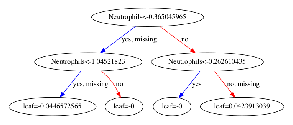

In [99]:
import matplotlib.pyplot as plt
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [100, 50]
plt.show()


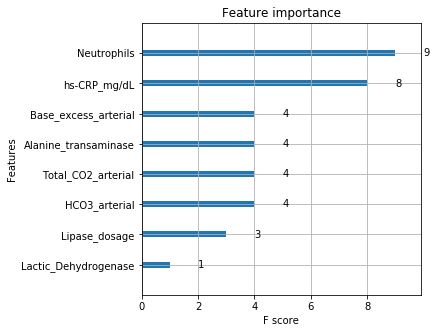

In [101]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()